In [1]:
import random
import itertools
import functools
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


import gudhi as gd
from gudhi.wasserstein import wasserstein_distance
import torch
torch.set_default_dtype(torch.float64) 
import torch.nn as nn

In [2]:
# I WANT TO COMPARE CLOUDS WITH 1K POINTS WITH THE SAME STARTING POINT
def generate_orbits(n_points_per_orbit = 1000, params = [2.5, 3.5, 4.0, 4.1, 4.3], same_init_point = True):
    # create point clouds 
    ORBITS = np.zeros([len(params), n_points_per_orbit, 2])
    xcur_0, ycur_0 = np.random.rand(), np.random.rand() # not necesary to save the first one
    for id_pc, param in enumerate(params): # id_point_cloud
        if same_init_point:
            xcur, ycur = xcur_0, ycur_0 # not necesary to save the first one
        else:
            xcur, ycur =np.random.rand(), np.random.rand()
        for id_pt in range(n_points_per_orbit): # id_point
            xcur = (xcur + param * ycur * (1. - ycur)) % 1
            ycur = (ycur + param * xcur * (1. - xcur)) % 1
            ORBITS[id_pc, id_pt, :] = [xcur, ycur]
    return ORBITS

# function from [len(params), n_points, 2] to alpha-complex and persistence diagram
# to create PDs we need to: points -> skeleton(ac) -> simplex(st) -> persistence(pers)
# for each element of the dataset we'll have len(params) PDs to be compared
def extract_PD(cloud, id_class):
    """extract a dict 

    Args:
        cloud (_type_): array [1000,2] composing th ewhole point cloud
        id_class (_type_): index about the class of membership

    Returns:
        dict: with keys ['persist_0','persist_1','id_class']
    """
    # for every point cloud we create a dictionary storing the label and its persistence
    # usage of dictionary to store each other possible data linked to the point clous
    ac = gd.AlphaComplex(points=cloud)
    st = ac.create_simplex_tree()
    pers = st.persistence()
    
    #! TRANSPOSE TO HAVE THEN [BATCH SIZE, 2, NUM POINTS]
    pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()[:,:-1]
    lengths_0 = pers_0[1] - pers_0[0]
    sorted_indices_desc_0 = np.argsort(-lengths_0)
    sorted_pers_0 = pers_0[:,sorted_indices_desc_0]*1000

    pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()
    lengths_1 = pers_1[1] - pers_1[0]
    sorted_indices_desc_1 = np.argsort(-lengths_1)
    sorted_pers_1 = pers_1[:,sorted_indices_desc_1]*1000

    pers_dict = {
        'persist_0': sorted_pers_0, # removing the last barcode, the one with inf
        'persist_1': sorted_pers_1, # here we should never have inf, since [0,1]^2 is compact/bounded  
        # 'persist': pers, # actual PD
        'id_class': id_class # label for classification
    }
    return pers_dict

In [3]:
# hyper params
n_points = 1000
params = [2.5, 3.5, 4.0, 4.1, 4.3]
same_init_point = True
n_seq_per_dataset = [70, 30] # [size train, size test] for each class

extended_pers = False # to be implemented, at the moment not interested in

# init list fo persistence diagrams
pds_train = []
pds_test = []

# TRAIN 
for i in tqdm(range(n_seq_per_dataset[0]), desc='Create TRAIN Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_train.append(ij_pers) # STORE IN THE LIST pds_train

# TEST
for i in tqdm(range(n_seq_per_dataset[1]), desc='Create TEST Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_test.append(ij_pers) # STORE IN THE LIST pds_test

Create TEST Point Clouds: 100%|██████████| 30/30 [00:01<00:00, 16.88it/s]


In [4]:
test_classes = np.array([pds_test[i]['id_class'] for i in range(len(pds_test))])

In [5]:
test_classes

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
       4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0,
       1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2,
       3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
       0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

---
> DISTANCES AMONG EACH BARCODE

In [9]:
# zip(pds_test[0]['persist_0'], pds_test[0]['persist_1'])
np.concatenate((pds_test[0]['persist_0'].transpose(), pds_test[0]['persist_1'].transpose()), axis = 0)

array([[0.        , 1.04171713],
       [0.        , 1.04154343],
       [0.        , 0.99782653],
       ...,
       [0.52587609, 0.52587615],
       [0.08077669, 0.08077673],
       [0.37596882, 0.37596883]])

In [8]:


index = 20


I0 = np.concatenate((pds_test[index]['persist_0'].transpose(), pds_test[index]['persist_1'].transpose()), axis = 0)
I1 = np.concatenate((pds_test[-index]['persist_0'].transpose(), pds_test[-index]['persist_1'].transpose()), axis = 0)
print(wasserstein_distance(I0, I1, order=1., internal_p=2.)) # default
I0 = np.array(pds_test[index]['persist_0']).transpose()
I1 = np.array(pds_test[-index]['persist_0']).transpose()
print(wasserstein_distance(I0, I1, order=1., internal_p=2.)) # default
I0 = np.array(pds_test[index]['persist_1']).transpose()
I1 = np.array(pds_test[-index]['persist_1']).transpose()
print(wasserstein_distance(I0, I1, order=1., internal_p=2.)) # default

# ord = 1. # EXPONENT FOR WASSERSTEIN
# int_p = 2. # ground metric in the plane, R^2

# dist11 = wasserstein_distance(I0, I1, order=1., internal_p=1.)
# dist12 = wasserstein_distance(I0, I1, order=1., internal_p=2.) # default
# dist21 = wasserstein_distance(I0, I1, order=2., internal_p=1.)
# dist22 = wasserstein_distance(I0, I1, order=2., internal_p=2.)

33.96100696436456
5.457698275255936
28.898292940117127


USING BEST 50 OF H0 AND H1

In [28]:
# INTRACLASS
dists = []
preproc = 200

for intra_class in [0,1,2,3,4]:
    starting_test_pds_for_distances = [np.concatenate((pds_test[i]['persist_0'][:,:preproc].transpose(), pds_test[i]['persist_1'][:,:preproc].transpose()), axis = 0) for i in range(len(pds_test))]
    for i in range(intra_class, len(pds_test), 5):
        for j in range(i, len(pds_test), 5):
            print(j, end = ' ')
            dists.append(wasserstein_distance(starting_test_pds_for_distances[i], starting_test_pds_for_distances[j], order=1., internal_p=2.))
    print(f'\n CLASS {intra_class} > {min(dists) = }, {max(dists) = }')

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 6

In [9]:
# ALL CLASSES
# if run multiple times same results: OK!
dists = {}
for i in range(5):
    for j in range(5):
        dists[f'{i}{j}'] = []

preproc = 200 # maybe small for futher experiments

starting_test_pds_for_distances = [np.concatenate((pds_test[i]['persist_0'][:,:preproc].transpose(), pds_test[i]['persist_1'][:,:preproc].transpose()), axis = 0) for i in range(len(pds_test))]
for i in tqdm(range(len(pds_test)), desc= f'DISTANCES AMONG ALL PDS'):
    for j in range(i, len(pds_test)):
        dists[f'{(i%5)}{(j%5)}'].append(wasserstein_distance(starting_test_pds_for_distances[i], starting_test_pds_for_distances[j], order=1., internal_p=2.))


DISTANCES AMONG ALL PDS: 100%|██████████| 150/150 [03:04<00:00,  1.23s/it]


In [10]:
class_a = 2
class_b = 3
max( max(dists[f'{class_a}{class_b}']), max(dists[f'{class_b}{class_a}']) )

115.8335276601913

In [11]:
max_dists = np.zeros((5,5))
for k,q in dists.items():
    max_dists[int(k[0]), int(k[1])] = max(q)

min_dists = np.zeros((5,5))
for k,q in dists.items():
    min_dists[int(k[0]), int(k[1])] = min(q)

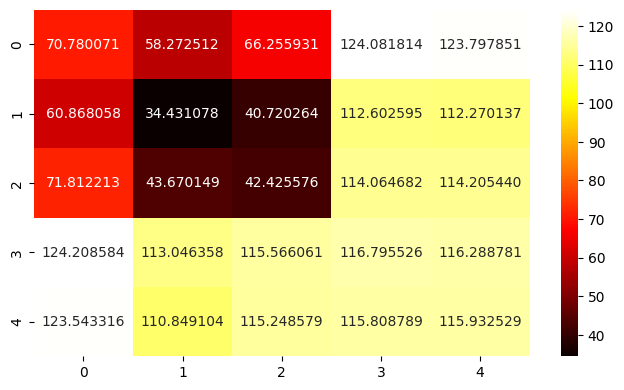

In [42]:
considered_clouds = [0,1,2,3,4]
plt.figure(figsize=(3 + 1.*len(considered_clouds), 2 + 0.5*len(considered_clouds)))
sns.heatmap(max_dists, cmap='hot', annot=True, fmt=".6f", xticklabels=considered_clouds, yticklabels=considered_clouds, cbar=True)
plt.show()

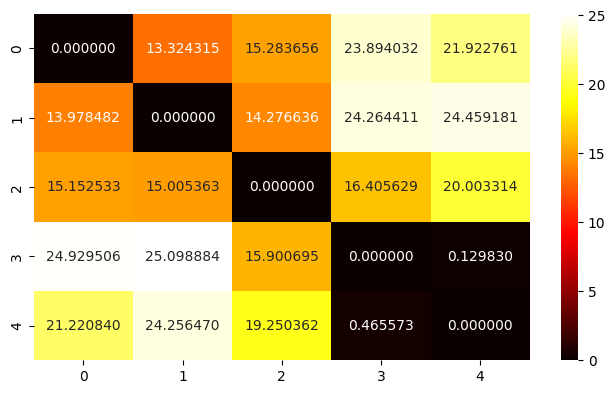

In [39]:
considered_clouds = [0,1,2,3,4]
plt.figure(figsize=(3 + 1.*len(considered_clouds), 2 + 0.5*len(considered_clouds)))
sns.heatmap(min_dists, cmap='hot', annot=True, fmt=".6f", xticklabels=considered_clouds, yticklabels=considered_clouds, cbar=True)
plt.show()

---
> GENERATE STABLE RANKS and compute again distances

In [12]:
stabranks = []
for i in range(len(pds_test)):
    # bars of each barcode are already sorted by length
    # Take the same number of bars of the previous computations
    stabrank_0 = pds_test[i]['persist_0'][1] - pds_test[i]['persist_0'][0]
    stabrank_1 = pds_test[i]['persist_1'][1] - pds_test[i]['persist_1'][0]
    stabranks.append(np.concatenate(\
        (stabrank_0[:preproc], \
         stabrank_1[:preproc]), \
        axis = 0))


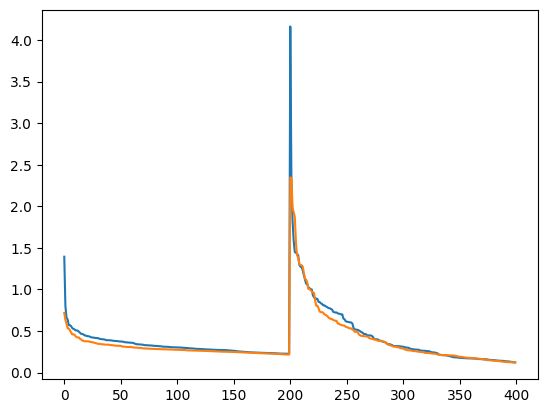

In [17]:
# Lp norm among stableranks
#! LOSING INFORMATIONS??

# set([ len(stabranks[index]) for index in range(len(stabranks))])
index = 2
plt.plot( stabranks[index])
plt.plot( stabranks[0])

In [13]:
sr_a = stabranks[0]
sr_b = stabranks[1]

def sr_norm(sr_1, sr_2, p):
    differences = np.abs(sr_1 - sr_2)
    # L_inf
    norm_linf = np.max(differences)
    # L_p
    powered_differences = differences ** p
    sum_of_powers = np.sum(powered_differences)
    norm_lp = sum_of_powers ** (1/p)
    return norm_lp, norm_linf

sr_distances_inf = {}
for i in range(5):
    for j in range(5):
        sr_distances_inf[f'{i}{j}'] = []

sr_distances_p = {}
for i in range(5):
    for j in range(5):
        sr_distances_p[f'{i}{j}'] = []

In [82]:
p = 2
for i in tqdm(range(len(stabranks)), desc= f'DISTANCES AMONG ALL STABLERANKS'):
    for j in range(len(stabranks)):
        sr_dist_inf, sr_dist_p = sr_norm(stabranks[i], stabranks[j], p)
        sr_distances_inf[f'{(i%5)}{(j%5)}'].append(sr_dist_inf)
        sr_distances_p[f'{(i%5)}{(j%5)}'].append(sr_dist_p)



DISTANCES AMONG ALL STABLERANKS:   0%|          | 0/150 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (400,) (201,) 

In [40]:
# now stable ranks as the length of bars in barcodes
num_dgs_train = len(pds_train)
num_dgs_test = len(pds_test)

# train
# todo: HERE I WANT ALSO TO APPLY A DENSITY IN SOME CASES 
barlength_train_H0 = np.array([np.sort(pds_train[i]['persist_0'][1] - pds_train[i]['persist_0'][0]) for i in range(num_dgs_train)]) # length of barcodes H0 (size always =999)
# todo: 
barlength_train_H1 = [np.sort(pds_train[i]['persist_1'][1] - pds_train[i]['persist_1'][0]) for i in range(num_dgs_train)] # length of barcodes H0 (size always =999)
# test
# todo: 
barlength_test_H0 = np.array([np.sort(pds_test[i]['persist_0'][1] - pds_test[i]['persist_0'][0]) for i in range(num_dgs_test)]) # length of barcodes H0 (size always =999)
# todo: 
barlength_test_H1 = [np.sort(pds_test[i]['persist_1'][1] - pds_test[i]['persist_1'][0]) for i in range(num_dgs_test)] # length of barcodes H0 (size always =999)

max_size_H0 = 999
max_size_train_H1 = max([i.shape[0] for i in barlength_train_H1])
print(f'{max_size_train_H1 = }')
max_size_test_H1 = max([i.shape[0] for i in barlength_test_H1])
print(f'{max_size_test_H1 = }')

# H0 TRAIN
train_vecs_H0 = np.zeros((num_dgs_train, max_size_H0))
for i in range(num_dgs_train):
    train_vecs_H0[i, :barlength_train_H0[i].shape[0]] = barlength_train_H0[i][::-1]

# H1 TRAIN
train_vecs_H1 = np.zeros((num_dgs_train, max_size_train_H1))
for i in range(num_dgs_train):
    train_vecs_H1[i, :barlength_train_H1[i].shape[0]] = barlength_train_H1[i][::-1]

# H0 TEST
test_vecs_H0 = np.zeros((num_dgs_test, max_size_H0))
for i in range(num_dgs_test):
    test_vecs_H0[i, :barlength_test_H0[i].shape[0]] = barlength_test_H0[i][::-1]

test_vecs_H1 = np.zeros((num_dgs_test, max_size_test_H1))
for i in range(num_dgs_test):
    test_vecs_H1[i, :barlength_test_H1[i].shape[0]] = barlength_test_H1[i][::-1]

train_classes = np.array([pds_train[i]['id_class'] for i in range(num_dgs_train)])
test_classes = np.array([pds_test[i]['id_class'] for i in range(num_dgs_test)])

train_vecs_H0 = train_vecs_H0[:,:preproc]*100 ##* TEMPERATURE??
train_vecs_H1 = train_vecs_H1[:,:preproc]*100
test_vecs_H0 = test_vecs_H0[:,:preproc]*100
test_vecs_H1 = test_vecs_H1[:,:preproc]*100

max_size_train_H1 = 996
max_size_test_H1 = 1006


---
> BATCHING DATA and NN

In [ ]:
batch_size = 256
n_train_batches = len(train_vecs_H0)//batch_size + 1
batched_train = []
for i in range(n_train_batches):
    batched_train.append(\
        [torch.tensor(train_vecs_H0[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(train_vecs_H1[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(train_classes[i*batch_size:(i+1)*batch_size])])
    
n_test_batches = len(test_vecs_H0)//batch_size + 1
batched_test = []
for i in range(n_test_batches):
    batched_test.append(\
        [torch.tensor(test_vecs_H0[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(test_vecs_H1[i*batch_size:(i+1)*batch_size,:]),\
        torch.tensor(test_classes[i*batch_size:(i+1)*batch_size])])